# Demonstration: 0K Lattice and Elastic Parameter Refinement

**Lucas M. Hale**, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

**Chandler A. Becker**, [chandler.becker@nist.gov](mailto:chandler.becker@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

**Zachary T. Trautt**, [zachary.trautt@nist.gov](mailto:zachary.trautt@nist.gov?Subject=ipr-demo), *Materials Measurement Science Division, NIST*.

Version: 2015-08-28

[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm)

- - -

## Software

This notebook was tested with:

- LAMMPS (Version 2015-03-27)

- Python (Version 2.7.6)

- IPython (Version 2.0.0)

- - -

## Introduction

This Notebook first hydrostatically strains a system and measures the system's Virial pressure as a function of the system dimensions.  Following this, the orthorhombic elastic constant matrix is calculated for each system dimension point and related to the measured hydrostatic pressure.

__Note:__ For non-cubic systems, applying a hydrostatic strain may not result in a truly hydrostatic pressure. 

Related calculations:

- tool-E-vs-r0: Computes the cohesive energy as a function of nearest neighbor distances for 0K unrelaxed structures

- tool-a-Cij-quick: 0K lattice and elastic parameter refinement

- tool-alat-full-relax: Complete orthorhombic relaxation of system and atoms for a range of temperatures

- tool-T-vs-Cij: Obtain elastic constants at a given temperature


- - -

##1. Initial Setup

1. __Necessary Python Libraries__: This is a list of the Python libraries used to run this code. 

2. __Necessary Parameters__: These are the parameters that need to be specified to run the code.

3. __Calculation Parameters__: These are user-specified parameters that control how the calculation proceeds, such as number of data points.

###1.1 Necessary Python Libraries

This is a list of the Python libraries used to run this code.

- Numpy can be found [here](http://www.numpy.org/).

- Matplotlib can be found [here](http://matplotlib.org/).

- iprp is contained in the IPR code download.

In [1]:
#Standard Python Libraries
import subprocess
import os
from copy import deepcopy
import sys

#Additional Python Libraries
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

#Custom package
sys.path.append('../IPR')  #This will change if you move the Notebook!
import iprpy

###1.2 Necessary Parameters

These are the parameters that need to be specified to run the code.

- lammps_exe is the directory location for the LAMMPS executable to use.

- working_dir is the working directory where you want this Notebook to run.

- pot_file is the name (and location) of the interatomic potential data model file associated with the potential you want to use. A default potential (Al-Si-Mg-Cu-Fe--JelinekB--2012) is embedded in Section 2.1 of this Notebook, and the associated interatomic potential data model file is embedded in Section 2.2. Other potentials and interatomic potential data models can be downloaded from the [NIST Interatomic Potential Repository](http://www.ctcms.nist.gov/potentials/).

- pot_dir is the directory location where any potential artifacts (i.e. eam setfl, meam library files) are located.

- proto_file is the name (and location) of a crystal prototype data model file. These files contain sets of parameters associated with generating different crystal prototypes. One example (fcc.json) is embedded in Section 2.3. Other crystal prototype data models can be downloaded from the [NIST Interatomic Potential Repository](http://www.ctcms.nist.gov/potentials/). 

- elements is a list of the elements to be associated with the unique lattice sites of the selected crystal prototype. Elemental prototypes (eg. fcc) will need only one element, while compounds (eg. CsCl) require multiple elements.

- alat are the zero pressure lattice constants for the system.  

In [2]:
#Specify LAMMPS run command
lammps_exe = 'C:\\users\\lmh1\\Documents\\lmp_serial.exe'

#Specify working directory
working_dir = 'tool-Cij-vs-P'
try:
    os.chdir(working_dir)
except:
    os.mkdir(working_dir)
    os.chdir(working_dir)
working_dir = os.getcwd()

#Specify interatomic potential data model file
potential_file = 'Al-Si-Mg-Cu-Fe--JelinekB--2012.json'

#Specify path to potential artifacts, (eam setfl file, meam library files, etc.)
potential_dir = working_dir

#Specify crystal prototype data model file
prototype_file = 'fcc.json'

#List the element symbol(s) to use
symbols = ['AlS']

#Give the zero pressure lattice constants
a = b = c = 4.0500
alpha = beta = gamma = 90.0

#Error out if angles are not 90 (for now...)
assert alpha == beta  and alpha == gamma and alpha == 90., 'Only orthorhombic boxes currently supported'

###1.3 Calculation Parameters

These are user-specified parameters that control how the calculation proceeds, such as number of data points.

- delta is the strain range to be explored. The system will go from -delta/2 to +delta/2 strain relative to the supplied alat values above.

- steps is the number of data points to take along the calculation range.

In [3]:
#Specify the strain range to explore
delta = 0.1

#Specify how many stain steps to take
steps = 100

##2. Additional Data Files

To make this notebook self-contained, we have embedded a few files.

1. __MEAM Potential.__ Generates library and parameter files for one MEAM potential.

2. __Potential Data Model.__ Collects all input parameters assoiciated with running the MEAM potential in LAMMPS.

3. __Prototype Data Model.__ Generates an instance of the crystal prototype data model used to generate various structures.

###2.1 MEAM Potential

This generates the library and parameter files associated with the following interatomic potential taken from the [NIST Interatomic Potential Repository](http://www.ctcms.nist.gov/potentials/):

__Al-Si-Mg-Cu-Fe--JelinekB--2012__

__Aluminum, Silicon, Magnesium, Copper, and Iron (Al, Si, Mg, Cu, and Fe) Alloys__

*B. Jelinek, S. Groh, M. Horstemeyer, J. Houze, S.G. Kim, G.J. Wagner, A. Moitra, and M.I. Baskes, "Modified embedded atom method potential for Al, Si, Mg, Cu, and Fe alloys," Phys. Rev. B 85, 245102 (2012).*

__Notes__: This file was provided by Bohumir Jelinek (Mississippi State University) and posted on 3 July 2012. He noted, "This is a MEAM potential for Al, Si, Mg, Cu, Fe alloys. It works with LAMMPS, version 19 Jul 2011 or later, when compiled with MEAM support."

__Notice__: Users should consider all available potentials and select one which is appropriate for their use case. Use of this potential within this demonstration should not be construed as an endorsement or a recommendation. 

In [4]:
#Create MEAM library and parameter files for the Al-Si-Mg-Cu-Fe--JelinekB--2012 potential
   
#Create MEAM library file "Jelinek_2012_meamf"
f = open('Jelinek_2012_meamf', 'w')
f.write("""# MEAM Al, Si, Mg, Cu, Fe alloy potential, Phys. Rev. B 85, 245102 (2012)
# http://dx.doi.org/10.1103/PhysRevB.85.245102
# to be used with "meam.alsimgcufe" file providing combinational parameters
#  elt        lat     z       ielement     atwt
#  alpha      b0      b1      b2           b3    alat    esub    asub
#  t0         t1              t2           t3            rozero  ibar

'AlS'        'fcc'   12.     13           26.9815
4.64        2.04    3.00    6.0          1.50  4.05    3.353    1.07
1.0         +4.50           -2.30        8.01          1.0    -5
'SiS'        'dia'   4.      14           28.086
4.87        4.4     5.5     5.5          5.5   5.431   4.63    1.
1.0         2.05            4.47         -1.80         2.2    -5
'MgS'       'hcp'   12.      12           24.305
5.52        4.0    3.0     0.2          1.2  3.194 1.51     0.80
1.0         10.04           9.49         -4.3          0.63   -5
'CuS'        'fcc'   12.     29           63.54
5.11        3.634   2.20    6            2.20  3.62    3.54    1.07
1.0         4.91            2.49         2.95          1.10   -5
'FeS'        'bcc'   8       26           55.847
5.0270      3.500   2       1.00         1     2.851   4.28    0.5550
1          -1.6             12.5          -1.40        1.0    -5""")
f.close()

#Create MEAM parameter file "Jelinek_2012_meam.alsimgcufe"
f = open('Jelinek_2012_meam.alsimgcufe', 'w')
f.write("""# MEAM Al, Si, Mg, Cu, Fe alloy potential, Phys. Rev. B 85, 245102 (2012)
# http://dx.doi.org/10.1103/PhysRevB.85.245102
# to be used with "meamf" file providing single element parameters

  Cmin(1,1,1) = 0.8
  repuls(1,1) = 0.1
  Cmin(3,3,3) = 0.8
  Cmin(4,4,4) = 0.8
  Cmin(5,5,5) = 0.68
  repuls(5,5) = 0.3
  Cmax(5,5,5) = 1.9

  nn2(1,1)=1
  nn2(1,2)=1
  nn2(1,3)=1
  nn2(1,4)=1
  nn2(1,5)=1
  nn2(2,2)=1
  nn2(2,3)=1
  nn2(2,4)=1
  nn2(2,5)=1
  nn2(3,3)=1
  nn2(3,4)=1
  nn2(3,5)=1
  nn2(4,4)=1
  nn2(4,5)=1
  nn2(5,5)=1

  lattce(1,2)='b1'
  delta(1,2)=+0.28
  alpha(1,2)=4.56
  re(1,2)=2.62
  Cmin(1,1,2) = 0.50
  Cmin(2,2,1) = 2.00
  Cmin(1,2,1) = 2.00
  Cmin(1,2,2) = 2.00

  lattce(1,3)='b1'
  delta(1,3)=+0.23
  alpha(1,3)=4.52
  re(1,3)=2.87
  Cmin(1,1,3) = 2.00
  Cmin(3,3,1) = 0.00
  Cmin(1,3,1) = 2.00
  Cmin(1,3,3) = 0.00

  lattce(1,4)='b1'
  delta(1,4)=+0.19
  alpha(1,4)=4.65
  re(1,4)=2.53
  Cmin(1,1,4) = 0.00
  Cmin(4,4,1) = 2.00
  Cmin(1,4,1) = 2.00
  Cmin(1,4,4) = 2.00

  lattce(1,5)='b1'
  delta(1,5)=+0.26
  alpha(1,5)=4.64
  re(1,5)=2.45
  Cmin(1,1,5) = 0.90
  Cmin(5,5,1) = 0.10
  Cmin(1,5,1) = 2.00
  Cmin(1,5,5) = 2.00

  lattce(2,3)='b1'
  delta(2,3)=+0.2
  alpha(2,3)=4.73
  re(2,3)=2.75
  Cmin(2,2,3) = 1.00
  Cmin(3,3,2) = 1.00
  Cmin(2,3,2) = 2.00
  Cmin(2,3,3) = 2.00

  lattce(2,4)='b1'
  delta(2,4)=+0.14
  alpha(2,4)=4.74
  re(2,4)=2.46
  Cmin(2,2,4) = 0.00
  Cmin(4,4,2) = 0.00
  Cmin(2,4,2) = 2.00
  Cmin(2,4,4) = 2.00

  lattce(2,5)='b1'
  delta(2,5)=-0.07
  alpha(2,5)=5.17
  re(2,5)=2.39
  Cmin(2,2,5) = 1.00
  Cmin(5,5,2) = 1.00
  Cmin(2,5,2) = 2.00
  Cmin(2,5,5) = 0.00
  attrac(2,5) = 0.1
  repuls(2,5) = 0.1

  lattce(3,4)='b1'
  delta(3,4)=+0.23
  alpha(3,4)=4.70
  re(3,4)=2.63
  Cmin(3,3,4) = 2.00
  Cmin(4,4,3) = 0.00
  Cmin(3,4,3) = 2.00
  Cmin(3,4,4) = 2.00

  lattce(3,5)='b1'
  delta(3,5)=+0.6
  alpha(3,5)=4.96
  re(3,5)=2.61
  Cmin(3,3,5) = 0.65
  Cmin(5,5,3) = 0.00
  Cmin(3,5,3) = 2.00
  Cmin(3,5,5) = 2.00

  lattce(4,5)='b1'
  delta(4,5)=+0.63
  alpha(4,5)=5.21
  re(4,5)=2.42
  Cmin(5,5,4)=0.00

  attrac(5,2) = 0.1
  repuls(5,2) = 0.1

  rc = 5.0
  ialloy=1
  augt1=0
  delr=0.25658351
  emb_lin_neg=1
  bkgd_dyn=1""")
f.close()

###2.2 Potential Data Model

This generates the interatomic potential data model file associated with the Al-Si-Mg-Cu-Fe--JelinekB--2012 potential.  Additional interatomic potential data model files can also be downloaded from the [NIST Interatomic Potential Repository](http://www.ctcms.nist.gov/potentials/).

In [5]:
#Creates a interatomic potential data model for using the MEAM potential in LAMMPS
f = open('Al-Si-Mg-Cu-Fe--JelinekB--2012.json', 'w')
f.write("""{
    "interatomicPotentialImplementationLAMMPS": {
        "potentialID": {
            "descriptionIdentifier": "Al-Si-Mg-Cu-Fe--JelinekB--2012"
        },
        "units": "metal",
        "atom_style": "atomic",
        "atom": [
            {
                "element": "Al",
                "symbol": "AlS"
            },
            {
                "element": "Si",
                "symbol": "SiS"
            },
            {
                "element": "Mg",
                "symbol": "MgS"
            },
            {
                "element": "Cu",
                "symbol": "CuS"
            },
            {
                "element": "Fe",
                "symbol": "FeS"
            }
        ],
        "pair_style": {
            "type": "meam"
        },
        "pair_coeff": {
            "term": [
                {
                    "file": "Jelinek_2012_meamf"
                },
                {
                    "symbolsList": "True"
                },
                {
                    "file": "Jelinek_2012_meam.alsimgcufe"
                },
                {
                    "symbols": "True"
                }
            ]
        }
    }
}""")
f.close()    

###2.3 Prototype Data Model

This generates the crystal prototype data model file associated with the fcc crystal prototype.  Additional crystal prototype data model files can also be downloaded from the [NIST Interatomic Potential Repository](http://www.ctcms.nist.gov/potentials/).

In [6]:
#Creates an instance of a crystal prototype data model for generating crystal structures.
f = open('fcc.json', 'w')
f.write("""{
    "crystalPrototype": {
        "crystalProtoypeID": { 
            "common": "face-centered cubic", 
            "tag": "fcc",
            "prototype": "Cu",
            "Strukturbericht": "A1"
        },            
        "crystalProtoypeInfo": { 
            "PearsonSymbol": "cF4",
            "spaceGroupTag": "F m -3 m",
            "SpaceGroupNumber": 225
        },
        "lattice": {
            "cubic": {
                "atomPositions": {
                    "site": {
                        "component": 1,
                        "atomCoordinates": [
                            {
                                "value": [0.0000000000000, 0.0000000000000, 0.0000000000000],
                                "unit": "scaled"
                            },                      
                            {
                                "value": [0.5000000000000, 0.5000000000000, 0.0000000000000],
                                "unit": "scaled"
                            },
                            {
                                "value": [0.5000000000000, 0.0000000000000, 0.5000000000000],
                                "unit": "scaled"
                            },
                            {
                                "value": [0.0000000000000, 0.5000000000000, 0.5000000000000],
                                "unit": "scaled"
                            }
                        ]
                    }
                }
            }
        }
    }
}""")
f.close()

##3. LAMMPS Script Generation Function(s)

This code generates the underlying LAMMPS script(s) for performing the necessary simulations. For all scripts, system_info and pair_info are required.  system_info is the LAMMPS script lines associated with either generating or reading in atomic system information.  pair_info is the LAMMPS script lines that assigns the atomic interaction model information.  

- alat_script() hydrostatically strains a systen over an entire strain range given by delta, and number of data points given by steps. The energy of each strain state is calculated without relaxation using run 0.  

- cij_script(). Subjects a system to independent xx, yy, zz, xy, xz znd yz strains and the energy of all states are obtained with "run 0". The system energies (and virial pressures) at these small strains allow for the elastic constants to be calculated. 

In [7]:
#Create a LAMMPS script that applies a hydrostatic strain.
def alat_script(system_info, pair_info, delta = 1e-5, steps = 2):
    
    nl = '\n'
    script = nl.join([system_info,
                      '',
                      pair_info,
                      '',
                      'variable lx0 equal lx',
                      'variable ly0 equal ly',
                      'variable lz0 equal lz',
                      '',
                      'variable deltax equal %f/%f' % (delta, steps-1),
                      'variable aratio equal 1-%f/2.+(v_a-1)*${deltax}' % (delta),
                      '',
                      'variable xmax equal v_aratio*${lx0}',
                      'variable ymax equal v_aratio*${ly0}',
                      'variable zmax equal v_aratio*${lz0}',
                      '',
                      'variable peatom equal pe/atoms',
                      'thermo_style custom step lx ly lz pxx pyy pzz v_peatom pe',
                      'thermo_modify format float %.13e',
                      '',
                      'label loop',
                      '',
                      'variable a loop %i' % (steps),
                      'change_box all x final 0 ${xmax} y final 0 ${ymax} z final 0 ${zmax} remap units box',
                      'run 0',
                      'next a','jump alat.in loop'])
    return script        

def cij_script(system_info, pair_info, delta = 1e-5, steps = 2):
#Create lammps script that strains a crystal in each direction x,y,z and shear yz,xz,xy independently.    
        
    nl = '\n'
    script = nl.join([system_info,
                      '',
                      pair_info,
                      '',
                      'variable lx0 equal $(lx)',
                      'variable ly0 equal $(ly)',
                      'variable lz0 equal $(lz)',
                      '',
                      'variable deltax equal %f/%f'%(delta, steps-1),
                      '',
                      'variable peatom equal pe/atoms',
                      'thermo_style custom step lx ly lz yz xz xy pxx pyy pzz pyz pxz pxy v_peatom pe',
                      'thermo_modify format float %.13e',
                      '',
                      'run 0',
                      '',
                      'variable aratio equal 1-%f/2.+(v_a-1)*${deltax}'%(delta),
                      'variable xmax equal v_aratio*${lx0}',
                      'label loopa',
                      'variable a loop %i'%(steps),
                      'change_box all x final 0 ${xmax} remap units box',
                      'run 0',
                      'next a','jump cij.in loopa',
                      'change_box all x final 0 ${lx0} remap units box',
                      '',
                      'variable bratio equal 1-%f/2.+(v_b-1)*${deltax}'%(delta),
                      'variable ymax equal v_bratio*${ly0}',
                      'label loopb',
                      'variable b loop %i'%(steps),
                      'change_box all y final 0 ${ymax} remap units box',
                      'run 0',
                      'next b','jump cij.in loopb',
                      'change_box all y final 0 ${ly0} remap units box',
                      '',
                      'variable cratio equal 1-%f/2.+(v_c-1)*${deltax}'%(delta),
                      'variable zmax equal v_cratio*${lz0}',
                      'label loopc',
                      'variable c loop %i'%(steps),
                      'change_box all z final 0 ${zmax} remap units box',
                      'run 0',
                      'next c','jump cij.in loopc',
                      'change_box all z final 0 ${lz0} remap units box',
                      '',
                      'change_box all triclinic',
                      'variable eyz equal (-%f/2.+(v_d-1)*${deltax})*${lz0}'%(delta),
                      'label loopd',
                      'variable d loop %i'%(steps),
                      'change_box all yz final ${eyz} remap units box',
                      'run 0',
                      'next d','jump cij.in loopd',
                      'change_box all yz final 0 remap units box',
                      '',
                      'variable exz equal (-%f/2.+(v_e-1)*${deltax})*${lz0}'%(delta),
                      'label loope',
                      'variable e loop %i'%(steps),
                      'change_box all xz final ${exz} remap units box',
                      'run 0',
                      'next e','jump cij.in loope',
                      'change_box all xz final 0 remap units box',
                      '',
                      'variable exy equal (-%f/2.+(v_f-1)*${deltax})*${ly0}'%(delta),
                      'label loopf',
                      'variable f loop %i'%(steps),
                      'change_box all xy final ${exy} remap units box',
                      'run 0',
                      'next f','jump cij.in loopf',
                      'change_box all xy final 0 remap units box'])
    return script

##4. Python Calculation Function(s)

These functions are associated with setting up the atomic systems, running LAMMPS, extracting the simulation data, and refining the results.

- cij_vs_p first strains the system from +-delta/2 for steps number of points using alat_script and measures the hydrostatic pressure using the Virial pressure.  Then, for every single strain step the elastic constants are calculated using cij_script. Finally, the measured pressures and elastic constants are related. 

In [8]:
def cij_vs_p(lammps_exe, ucell, potential, symbols, delta = 0.1, steps = 200):
#Computes the pressure dependent elastic constants in strain range "delta" for "steps" number of points   
    
    #initial parameter definitions
    pvalues = np.empty((steps))
    C11 = np.empty((steps))
    C22 = np.empty((steps))
    C33 = np.empty((steps))
    C12 = np.empty((steps))
    C13 = np.empty((steps))
    C23 = np.empty((steps))
    C44 = np.empty((steps))
    C55 = np.empty((steps))
    C66 = np.empty((steps))
    dimensions = np.empty((13,6))       
    stresses = np.empty((13,6))
    
    #LAMMPS script setup
    pair_info = potential.pair_info(symbols)
    
    system_info = iprpy.lammps.sys_gen(units =       potential.units(),
                                       atom_style =  potential.atom_style(),
                                       ucell_box =   ucell.box(),
                                       ucell_atoms = ucell.atoms(scale=True),
                                       size =        np.array([[0,3], [0,3], [0,3]], dtype=np.int))
    
    with open('alat.in','w') as f:
        f.write(alat_script(system_info, pair_info, delta=delta, steps=steps))
    data1 = iprpy.lammps.log_extract(subprocess.check_output(lammps_exe + ' -in alat.in', shell=True))
    
    #Extract pressures and associated lattice parameters
    for c in xrange(steps):
        newbox = iprpy.Box(a = float(data1[c+1][1]) / 3.,
                           b = float(data1[c+1][2]) / 3.,
                           c = float(data1[c+1][3]) / 3.)
        
        pvalues[c] = ((float(data1[c+1][4]) + float(data1[c+1][5]) + float(data1[c+1][6])) / 3. ) * 1e-4
        
        system_info = iprpy.lammps.sys_gen(units =       potential.units(),
                                           atom_style =  potential.atom_style(),
                                           ucell_box =   newbox,
                                           ucell_atoms = ucell.atoms(scale=True),
                                           size =        np.array([[0,3], [0,3], [0,3]], dtype=np.int))
        
        with open('cij.in','w') as f:
            f.write(cij_script(system_info, pair_info))
            
        data2 = iprpy.lammps.log_extract(subprocess.check_output(lammps_exe + ' -in cij.in', shell=True))
 
        #Extract system dimensions and pressures from LAMMPS data output
        for q in xrange(13):
            for p in xrange(6):
                dimensions[q, p] = float(data2[q+1][p+1])
                stresses[q, p] = -float(data2[q+1][p+7])*1e-4
        eps_scale = np.array([dimensions[0,0], dimensions[0,1], dimensions[0,2], 
                              dimensions[0,2], dimensions[0,2], dimensions[0,1]])

        #Calculate Cij from LAMMPS results
        cij = np.empty((6,6))
        for i in xrange(0,6):
            eps_ij = (dimensions[2*i+2, i] - dimensions[2*i+1, i]) / eps_scale[i]  
            for j in xrange(0,6):
                sig_ij = stresses[2*i+2, j] - stresses[2*i+1, j]
                cij[j,i] = sig_ij/eps_ij
        
        C11[c] = cij[0,0]
        C22[c] = cij[1,1]
        C33[c] = cij[2,2]
        C12[c] = cij[0,1]
        C13[c] = cij[0,2]
        C23[c] = cij[1,2]
        C44[c] = cij[3,3]
        C55[c] = cij[4,4]
        C66[c] = cij[5,5]
    
    return {'p':pvalues, 'C11':C11,'C22':C22,'C33':C33,
                         'C12':C12,'C13':C13,'C23':C23,
                         'C44':C44,'C55':C55,'C66':C66}

##5. Run Calculation and Display Results

This is the code that runs the calculation function(s) for the supplied inputs and displays the resulting data.

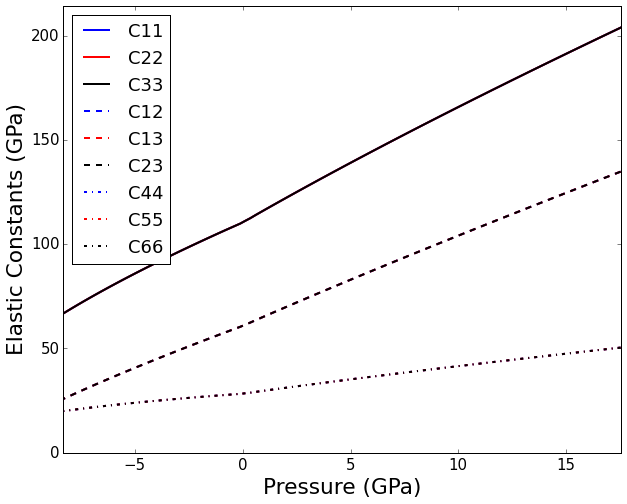

In [9]:
#Read the interatomic potential data model file
potential = iprpy.lammps.Potential(potential_file, potential_dir)
prototype = iprpy.models.Prototype(prototype_file)
ucell = prototype.ucell(a=a, b=b, c=c, alpha=alpha, beta=beta, gamma=gamma)

#Perform the Cij vs P calculation    
values = cij_vs_p(lammps_exe, ucell, potential, symbols, delta = delta, steps = steps)

#Find the maximum Cij value
ymax = max(max(values['C11']),max(values['C22']),max(values['C33']),
           max(values['C12']),max(values['C13']),max(values['C23']),
           max(values['C44']),max(values['C55']),max(values['C66']))

#Plot and make pretty
matplotlib.rc('lines',lw=2)
matplotlib.rc('font',size=15)
plt.figure(figsize=(10,8))

plt.plot(values['p'], values['C11'], 'b-',  label='C11', lw=2) 
plt.plot(values['p'], values['C22'], 'r-',  label='C22', lw=2)
plt.plot(values['p'], values['C33'], 'k-',  label='C33', lw=2)
plt.plot(values['p'], values['C12'], 'b--', label='C12', lw=2) 
plt.plot(values['p'], values['C13'], 'r--', label='C13', lw=2)
plt.plot(values['p'], values['C23'], 'k--', label='C23', lw=2)
plt.plot(values['p'], values['C44'], 'b-.', label='C44', lw=2) 
plt.plot(values['p'], values['C55'], 'r-.', label='C55', lw=2)
plt.plot(values['p'], values['C66'], 'k-.', label='C66', lw=2)

plt.legend(loc='upper left')
plt.xlabel('Pressure (GPa)',size='x-large')
plt.ylabel('Elastic Constants (GPa)',size='x-large')
plt.xlim(min(values['p']), max(values['p']))
plt.ylim(0, ymax * 1.05)
plt.show()